In [2]:
from dataset import (
    get_dataset, 
    save_map, 
    save_pred_map_to_tif
)
from metrics import (
    get_metrics,
    get_classification_metrics,
    get_feature_importances, 
    get_catboost_importances, 
)
from vis import (
    plot_image,
    plot_mask,
    plot_SCL,
    draw_maps,
)

import matplotlib.pyplot as plt
from rasterio.windows import Window
import pandas as pd
import wandb
import rasterio
import numpy as np
import tifffile as tiff
import wandb
from sklearn.model_selection import train_test_split

%load_ext autoreload
%autoreload 2   

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
path_S2B_list = [
    './data/tile_UTM38N/20180730/',
    './data/tile_UTM38N/20180804/',
    './data/tile_UTM38N/20180827/',
    './data/tile_UTM38N/20180911/',
    './data/tile_UTM38N/20190608/',
    './data/tile_UTM38N/20190613/',
    './data/tile_UTM38N/20200604/',
    './data/tile_UTM38N/20200709/',
]

channels = ['B02', 'B03', 'B04', 'B05', 'B06', 'B07', 'B08', 'B8A', 'B11', 'B12']

target = 'type'

In [8]:
# Get table with types and ages
y0, x0 = 6000, 0
window_n = Window.from_slices((y0, y0 + 4000), (x0, x0 + 2700))

y0, x0 = 0, 5700
window_r = Window.from_slices((y0, y0 + 7000), (x0, x0 + 10000))


### Test
y0, x0 = 7500, 2700
window_k = Window.from_slices((y0, y0 + 3000), (x0, x0 + 1200))

In [11]:
## Stacking of several dates
def stack_several_dates_dataset(path_S2B_list, 
                              target, 
                              channels_list=['B02'], 
                              window=None, 
                              indices=False):
    dataset_list = []
    ch_list = channels_list + [target]

    for path_S2B in path_S2B_list:
        dataset = get_dataset(
            path_S2B, 
            channels_list=ch_list, 
            window=window, 
            visualise=False, 
            indices=indices,
            apply_SCL=False)
        
        dataset = dataset[dataset[target] > 0]
        
        #### классификация:
        # dataset = dataset.query('(`type` == 1) | (`type` == 2) | (`type` == 5)')

        # dataset = dataset[dataset[target] != 3]
        dataset_list.append(dataset)

    dataset = pd.concat(dataset_list)
        
    return dataset

In [ ]:
dataset = pd.concat([
    stack_several_dates_dataset(path_S2B_list, target, channels_list=channels, window=window_n, indices=True),
    stack_several_dates_dataset(path_S2B_list, target, channels_list=channels, window=window_r, indices=True),
])

Y = dataset[target]
X = dataset.drop(labels=[target, 'x', 'y'], axis=1)

In [ ]:
np.unique(Y)

In [10]:
X_train, X_test1, Y_train, Y_test1 = train_test_split(X, Y, test_size=0.2, random_state=0)
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.15, random_state=0)

print(len(X_train), len(X_val), len(X_test1))
print(f'Train proportion: {len(X_train)/len(X):.3f}')
print(f'Val proportion: {len(X_val)/len(X):.3f}')
print(f'Test_random proportion: {len(X_test1)/len(X):.3f}')
# print(f'Test_window proportion: {len(X_test)/len(X):.3f}')

51233029 9041123 15068538
Train proportion: 0.680
Val proportion: 0.120
Test_random proportion: 0.200


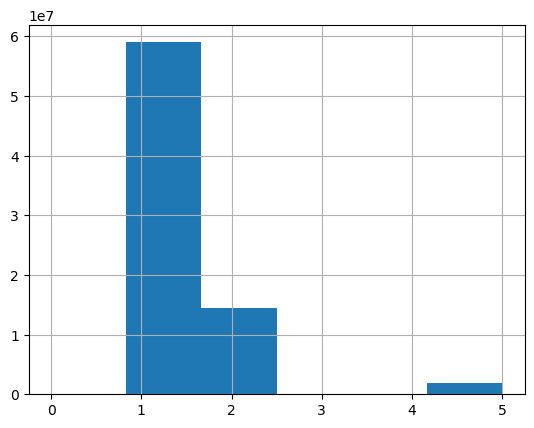

In [11]:
%matplotlib inline
Y.hist(bins=6, range=(0, 5));

In [12]:
import os
import wandb

os.environ["WANDB__SERVICE_WAIT"] = "300"

In [13]:
run = wandb.init(
  project="forest-co2",
  notes=f"Channels {channels}. Date: {path_S2B_list}. SCL=4",
  tags=[target]
)

wandb: Currently logged in as: nali. Use `wandb login --relogin` to force relogin


In [14]:
_, counts = np.unique(Y_train, return_counts=True)
class_weights = 1 / counts
print(f'class_weights: {class_weights}')
print(f'counts in train: {counts}')

class_weights: [2.49365552e-08 1.01277227e-07 7.95310215e-07]
counts in train: [40101770  9873888  1257371]


In [15]:
from catboost import CatBoostClassifier, Pool

train_data = Pool(data=X_train, 
                  label=Y_train,
                 )

val_data = Pool(data=X_val, 
                label=Y_val,
               )

params = {
    'learning_rate': 0.35, 
    'class_weights': class_weights,
    'max_depth': 6,
    'loss_function': 'MultiClass',  
    'custom_metric': ['Precision', 'Recall', 'Accuracy'],
    'eval_metric': 'TotalF1:average=Macro', 
    'metric_period': 100,
    'iterations': 10000,
    'verbose': 1000, 
    'task_type': "GPU",
    'use_best_model': True,
    }

model = CatBoostClassifier(**params)

model.fit(
    train_data, 
    eval_set=val_data, 
    plot=True,
    # plot_file=f'./plots/train_{run.name}.json', 
    # save_snapshot=True,
    # snapshot_interval=600, 
) 

TBB Warning: The number of workers is currently limited to 15. The request for 127 workers is ignored. Further requests for more workers will be silently ignored until the limit changes.



MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6418186	test: 0.6416641	best: 0.6416641 (0)	total: 187ms	remaining: 31m 5s
1000:	learn: 0.7141570	test: 0.7141694	best: 0.7141694 (1000)	total: 1m 15s	remaining: 11m 19s
2000:	learn: 0.7262383	test: 0.7262846	best: 0.7262846 (2000)	total: 2m 31s	remaining: 10m 7s
3000:	learn: 0.7331435	test: 0.7332811	best: 0.7332811 (3000)	total: 3m 46s	remaining: 8m 49s
4000:	learn: 0.7385825	test: 0.7387555	best: 0.7387555 (4000)	total: 5m 2s	remaining: 7m 33s
5000:	learn: 0.7417473	test: 0.7418630	best: 0.7418630 (5000)	total: 6m 16s	remaining: 6m 16s
6000:	learn: 0.7448946	test: 0.7449465	best: 0.7449465 (6000)	total: 7m 32s	remaining: 5m 1s
7000:	learn: 0.7462916	test: 0.7463449	best: 0.7463449 (7000)	total: 8m 44s	remaining: 3m 44s
8000:	learn: 0.7466932	test: 0.7467553	best: 0.7467553 (8000)	total: 9m 52s	remaining: 2m 28s
9000:	learn: 0.7475696	test: 0.7475825	best: 0.7475825 (9000)	total: 11m 1s	remaining: 1m 13s
9999:	learn: 0.7484267	test: 0.7484703	best: 0.7484703 (9999)	total:

In [16]:
model.save_model(f"./weights/exp={run.name}_id={run.id}")

In [17]:
model.save_model(
    f"./weights/exp={run.name}_id={run.id}.json",
    format="json",
    pool=train_data
)

In [18]:
wandb.sklearn.plot_feature_importances(model, model.feature_names_)

In [19]:
model.classes_

array([1, 2, 5])

In [22]:
test_list = []
ch_list = channels + [target]

for path_S2B in path_S2B_list:
    dataset = get_dataset(
        path_S2B, 
        channels_list=ch_list, 
        window=window_k, 
        visualise=False, 
        indices=True)

    dataset = dataset[dataset[target] > 0]

    #### классификация:
    # dataset = dataset.query('(`1layer_main_species` == 1) | (`1layer_main_species` == 2) | (`1layer_main_species` == 3) | (`1layer_main_species` == 4) | (`1layer_main_species` == 5) | (`1layer_main_species` == 9)')
    dataset = dataset.query('(`type` == 1) | (`type` == 2) | (`type` == 5)')

    
    test_list.append(dataset)

In [23]:
from sklearn.metrics import (
    mean_absolute_percentage_error, 
    mean_absolute_error, 
    mean_squared_error, 
    confusion_matrix, 
    classification_report
)
import plotly_express as px

In [24]:
names = [path.split('/')[-2] for path in path_S2B_list]

for i, name in enumerate(names):
    test_dataset = test_list[i]
    Y_eval = test_dataset[target]
    X_eval = test_dataset.drop(labels=[target, 'x', 'y'], axis=1)
    
    Y_pred = model.predict(X_eval) # test_dataset['var1']
    
    transdict = {1: 'Spruce', 2: 'Birch', 3: 'Mix', 4: 'Aspen', 5: 'Pine'}
    model_classes = [transdict[class_] for class_ in model.classes_]

    fig = px.imshow(confusion_matrix(Y_eval, Y_pred), 
                    text_auto=True, 
                    x=model_classes, 
                    y=model_classes,
                    labels=dict(x="Predicted", y="Actual")
                   )
    wandb.log({name + '_fig': fig})
    
    
    
    report = classification_report(Y_eval, Y_pred, output_dict=True, target_names=model_classes)
    result_table = wandb.Table(columns=['class', 'precision', 'recall', 'f1-score', 'support'])
    for class_name, res_dict in report.items():
        if class_name != 'accuracy':
            p = res_dict['precision']
            r = res_dict['recall']
            f1 = res_dict['f1-score']
            supp = res_dict['support']
            result_table.add_data(class_name, round(p, 3), round(r, 3), round(f1, 3), supp)
    acc = report['accuracy']
    result_table.add_data('accuracy', round(acc, 3), round(acc, 3), round(acc, 3), round(acc, 3))
    run.log({name + "_table": result_table})